In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('colorblind')
sns.set_style('whitegrid')
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
!pip install contractions
import contractions
import re
from tqdm import tqdm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.8 MB/s eta 0:00:00


# Exploratory Data Analysis

We will start by loading our data, then dropping any duplicates. After that we will check the shape to understand the amount of data we are working with.

In [3]:
movies = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
display(movies.head())
movies.drop_duplicates(inplace = True)
print(movies.shape)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


(49582, 2)


We can see that our data has 49582 records and 2 columns. This is a lot of data especially when you consider that it is a Natural Language Processing task we are working on. As such, we will take a random sample of 10000 records to work with.

## Sampling

In [4]:
movies_copy = movies.copy()
movies_df = movies_copy.sample(n = 10000, random_state = 42).reset_index(drop = True)
display(movies_df.head())

,review,sentiment
0,"""Soul Plane"" is a horrible attempt at comedy t...",negative
1,Guest from the Future tells a fascinating stor...,positive
2,"""National Treasure"" (2004) is a thoroughly mis...",negative
3,"OK. First said, I just wanted to check whether...",negative
4,"I haven't always been a fan, but the show grew...",positive


## How many positive and negative reviews are there?

We will use a countplot to answer the above asked question;

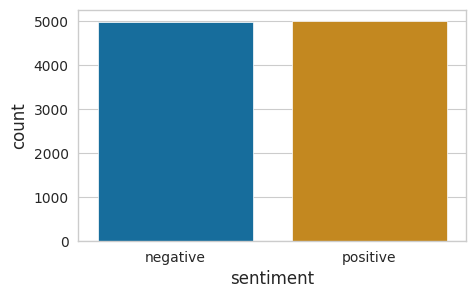

In [5]:
plt.figure(figsize = (5,3))
sns.countplot(data = movies_df, x = 'sentiment')
plt.show()

From the above countplot, we can see that negative and positive reviews are balanced. This is good as the Machine Learning models that will be fit later to predict sentiment will have a lot of data to learn from, from both classes.

Next, we will start text preprocessing.

We start by changing all words in our reviews to lowercase.

In [6]:
movies_df['review'] = tqdm(movies_df['review'].str.lower())

100%|██████████| 10000/10000 [00:00<00:00, 2685385.75it/s]


Next, we will expand contractions

In [7]:
tqdm.pandas()
movies_df['review'] = movies_df['review'].progress_apply(lambda x: contractions.fix(x))

100%|██████████| 10000/10000 [00:00<00:00, 12088.57it/s]


In [8]:
non_tagged = [re.sub(r'<br\s*/?>', '', text) for text in movies_df['review']]
review_tokens = [word_tokenize(sentence) for sentence in tqdm(non_tagged)]
review_alphanumeric = [
    [word for word in token if re.match(r"^[a-zA-Z0-9()]+$", word)]  # Keeps alphanumeric and parentheses
    for token in review_tokens
]


100%|██████████| 10000/10000 [00:13<00:00, 738.55it/s]


In [9]:
movies_df['clean_reviews'] = [' '.join(review) for review in review_alphanumeric]
display(movies_df.clean_reviews[:8])
display(movies_df.review[:8])

0    soul plane is a horrible attempt at comedy tha...
1    guest from the future tells a fascinating stor...
2    national treasure ( 2004 ) is a thoroughly mis...
3    first said i just wanted to check whether this...
4    i have not always been a fan but the show grew...
5    recovery is an incredibly moving piece of work...
6    awful movie it is a shame that a few of flande...
7    his significant charisma and commanding presen...
Name: clean_reviews, dtype: object

0    "soul plane" is a horrible attempt at comedy t...
1    guest from the future tells a fascinating stor...
2    "national treasure" (2004) is a thoroughly mis...
3    ok. first said, i just wanted to check whether...
4    i have not always been a fan, but the show gre...
5    recovery is an incredibly moving piece of work...
6    awful movie. it is a shame that a few of fland...
7    his significant charisma and commanding presen...
Name: review, dtype: object

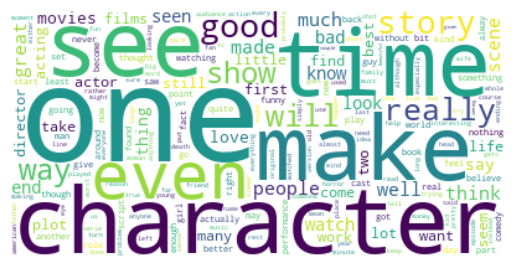

In [10]:
text = ' '.join(movies_df['clean_reviews'])
my_wordcloud = WordCloud(background_color = 'white', stopwords = STOPWORDS.union(['movie','film'])).generate(text)
plt.imshow(my_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [11]:
positive_df = movies_df[movies_df['sentiment']=='positive']
negative_df = movies_df[movies_df['sentiment']=='negative']
positive_text = ' '.join(positive_df['clean_reviews'])
negative_text = ' '.join(negative_df['clean_reviews'])

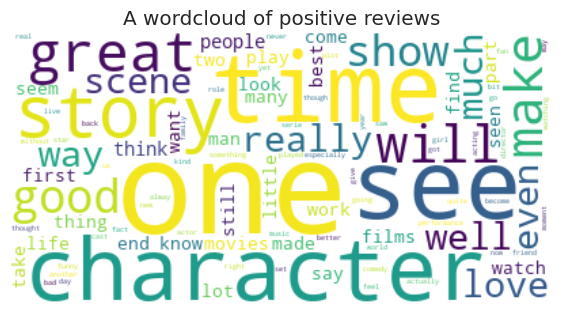

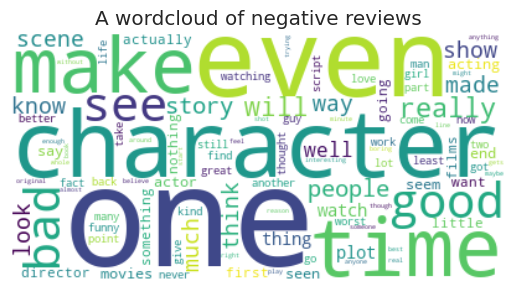

In [12]:
positive_wordcloud = WordCloud(max_words=100, background_color = 'white', stopwords = STOPWORDS.union(['movie','film'])).generate(positive_text)
negative_wordcloud = WordCloud(max_words=100, background_color = 'white', stopwords = STOPWORDS.union(['movie','film'])).generate(negative_text)
plt.figure(figsize = (7,5))
plt.imshow(positive_wordcloud, interpolation = 'bilinear')
plt.title('A wordcloud of positive reviews')
plt.axis('off')
plt.show()
plt.imshow(negative_wordcloud, interpolation = 'bilinear')
plt.title('A wordcloud of negative reviews')
plt.axis('off')
plt.show()

## Is there a significant difference between the length of reviews based on sentiment?

In [13]:
list_of_lengths = [len(word_tokenize(sent)) for sent in tqdm(movies_df['clean_reviews'])]

100%|██████████| 10000/10000 [00:07<00:00, 1416.52it/s]


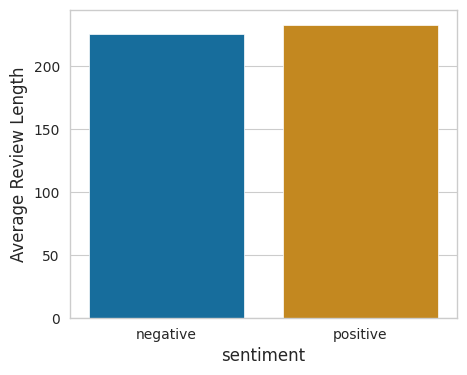

In [14]:
movies_df['review_length'] = list_of_lengths
plt.figure(figsize = (5,4))
sns.barplot(data = movies_df, x = 'sentiment', y = 'review_length',ci = False)
plt.ylabel('Average Review Length')
plt.show()

# Preprocessing

## Encoding sentiment

In [15]:
labelencoder = LabelEncoder()
movies_df['sentiment'] = labelencoder.fit_transform(movies_df['sentiment'])

In [16]:
movies_df.head()

,review,sentiment,clean_reviews,review_length
0,"""soul plane"" is a horrible attempt at comedy t...",0,soul plane is a horrible attempt at comedy tha...,138
1,guest from the future tells a fascinating stor...,1,guest from the future tells a fascinating stor...,273
2,"""national treasure"" (2004) is a thoroughly mis...",0,national treasure ( 2004 ) is a thoroughly mis...,607
3,"ok. first said, i just wanted to check whether...",0,first said i just wanted to check whether this...,651
4,"i have not always been a fan, but the show gre...",1,i have not always been a fan but the show grew...,716


In [17]:
y = movies_df['sentiment']
vect = CountVectorizer(max_features = 100000, ngram_range=(1,2))
vect.fit(movies_df['clean_reviews'])
X = vect.transform(movies_df['clean_reviews'])
X_df = pd.DataFrame(X.toarray(), columns = vect.get_feature_names_out())
X_df.shape

(10000, 100000)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.33, random_state=42, stratify = y)

In [19]:
from cuml.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
logistic_regression.score(X_test, y_test)

0.8527272939682007

In [20]:
y_pred = logistic_regression.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1645
           1       0.84      0.87      0.86      1655

    accuracy                           0.85      3300
   macro avg       0.85      0.85      0.85      3300
weighted avg       0.85      0.85      0.85      3300



In [21]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8184848484848485

In [22]:
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1645
           1       0.81      0.84      0.82      1655

    accuracy                           0.82      3300
   macro avg       0.82      0.82      0.82      3300
weighted avg       0.82      0.82      0.82      3300



In [23]:
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.8233333333333334

In [24]:
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB()
naive.fit(X_train, y_train)
naive.score(X_test, y_test)

0.8487878787878788